In [ ]:
# ! wget https://www.dropbox.com/s/znlx4inzbg362mf/dataset_lakes.zip?dl=0

In [ ]:
# ! unzip dataset_lakes.zip?dl=0

In [ ]:
# ! wget https://yadi.sk/d/TKvk4qhIF_00tQ

In [ ]:
# ! unzip archive.zip

In [ ]:
# ! pip install cv2
# ! pip install opencv-python==4.1.2.30

In [ ]:
#! wget 'https://downloader.disk.yandex.ru/disk/a18704c765e968739a88ff40033cbb736b1133334cc3fee0fb6b9d9cfb49d374/5f63e89d/IFnibbT4du1z8dM_41qrIAcEJm37SutnVq4DhHpd53xhaIawWYlQjnHIdDe0eVnGs6__OxhB770y-urI9UvI8Q%3D%3D?uid=0&filename=Archive.zip&disposition=attachment&hash=Byicd/NluoTMcvGFw7dAKjoSDPlDQL2XEK7p%2Bq0dzaoVDtaBTqPMEtSwEutrFadyq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=1159960430&fsize=1740772866&hid=79ac6e9bbf701042899cdc4ac3a53320&media_type=compressed&tknv=v2' -O archive.zip

In [1]:
import shutil
import cv2
import os
import imagecodecs
import scipy
import scipy.ndimage

from skimage.io import imread
import tifffile
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from p_tqdm import p_map


In [ ]:

# M = tifffile.imread('masks/M-33-20-D-c-4-2.tif')
# fname = 'M-33-48-A-c-4-4.tif'

LANDCOVER_MASK_DIR = 'masks'
LANDCOVER_IMAGE_DIR = 'images'

os.makedirs('intermediate', exist_ok=True)


def process_mask(M, dataset):
    if dataset == 'LANDCOVER':
        M[M != 3] = 0
        M[M == 3] = 255
    return M

def imread(fname, dataset):
    if dataset == 'LANDCOVER':
        M = tifffile.imread(f'{LANDCOVER_MASK_DIR}/' + fname)
        I = tifffile.imread(f'{LANDCOVER_IMAGE_DIR}/' + fname)
        process_mask(M, 'LANDCOVER')
    I = np.concatenate([I, M[..., None]], axis=-1)
    return I

#def split_image(im, H, W):
 #   tiles = [im[i:i+H,j:j+W] for i in range(0,im.shape[0]-H,H) for j in range(0,im.shape[1]-W,W)]
 #   return tiles

def get_rotated_crops(I, angle, crop_size=(448,448), num_crops=2):
    if angle == 0:
        mask = np.zeros_like(I[:, :, 0])
        mask[:mask.shape[0]-crop_size[0], :mask.shape[1]-crop_size[1]] = 1
        II = I
    else:
        angler = angle * np.pi / 180
        II = scipy.ndimage.rotate(I, angle)
        mask = scipy.ndimage.rotate(np.ones_like(I[:, :, 0]), angle)
        kernel = np.ones((crop_size[0] + 1, crop_size[1] + 1), dtype=np.uint8)
        mask = cv2.erode(mask, kernel, anchor=(0,0))
    
    x, y = mask.nonzero()
    L = len(x)
    for c in np.random.randint(0, L, size=num_crops):
        x0 = x[c]
        y0 = y[c]
        yield II[x0:x0 + crop_size[0], y0:y0 + crop_size[1]]


tiles = []
j = 0
# for fname in tqdm(os.listdir(LANDCOVER_IMAGE_DIR)):
def process(fname):
    tiles = []
    if not fname.endswith('tif'):
        return #tiles
        #continue
    I = imread(fname, 'LANDCOVER')
    #j += 1
    print(fname)
   
    for angle in (0, 10, 20, 30, 40, 50, 60, 70, 80):
    # for angle in (0, 10):
        for i, patch in enumerate(get_rotated_crops(I, angle, num_crops=1000)):
            if patch[:, :, -1].max() == 0 or patch[:, :, -1].min() == 255:
                continue
            base_fname = fname.split(".")[0]
            Image.fromarray(patch).save(f'intermediate/{base_fname}-{i}-{angle}.png')
            # print(i, type(patch), len(patch), angle)
            # tiles.append([patch, angle, fname, i])
#             if i >= 1:
#                 break
#     if j>=1:
#         break
    # return tiles

# tiles = p_map(process, os.listdir(LANDCOVER_IMAGE_DIR)[:8])
tiles = p_map(process, os.listdir(LANDCOVER_IMAGE_DIR))

In [ ]:
!ls intermediate | wc -l

In [ ]:
1 + 1

In [ ]:
# tiles = [item for group in tiles for item in group]
# len(tiles)
# tiles[28][1]

In [ ]:
ftest = f'intermediate/M-33-20-D-d-3-3-115-20.png'
I = np.asarray(Image.open(ftest))
I.shape

In [ ]:
cv2.imread(ftest, cv2.IMREAD_UNCHANGED)[:, :, -1].mean() // (0.1 * 255)

In [ ]:
from IPython.display import Image as Img
Img(filename=ftest) 

In [ ]:
plt.imshow(I[:, :, 3])

In [ ]:
plt.imshow(I[:, :, :3])

In [6]:
%%time
import os
from collections import Counter

# check_initial = Counter([cv2.imread(f'intermediate/{fname}', cv2.IMREAD_UNCHANGED)[:, :, -1].mean() // (0.1 * 255) 
#                 for fname  in os.listdir('intermediate') if (fname.endswith('.png') and np.asarray(Image.open(f'intermediate/{fname}')).shape == (448, 448, 4))])

def create_distribution(fname):
    if not fname.endswith('.png'):
        return None
    I = cv2.imread(f'intermediate/{fname}', cv2.IMREAD_UNCHANGED)
    if I is None:
        return None
    if I.shape != (448, 448, 4):
        return None
    return I[:, :, -1].mean() // (0.1 * 255), fname

from multiprocessing import Pool
with Pool(20) as p:
    distrib = p.map(create_distribution, os.listdir('intermediate'))

    
#Counter(filter(None, distrib))
check_initial = Counter(map(lambda x: x[0], filter(lambda x: x is not None, distrib)))
print(check_initial)

Counter({0.0: 20081, 1.0: 4604, 9.0: 3562, 2.0: 3031, 3.0: 2185, 4.0: 1939, 8.0: 1906, 5.0: 1731, 6.0: 1682, 7.0: 1667})
CPU times: user 294 ms, sys: 328 ms, total: 622 ms
Wall time: 27.1 s


In [9]:
from collections import defaultdict
use_fnames = defaultdict(list)
for mean, fname in filter(lambda x: x is not None, distrib):
    if len(use_fnames[mean]) < 5000:        
        use_fnames[mean].append(fname)
use_fnames = [fname for mean in use_fnames for fname in use_fnames[mean]]

In [10]:
len(use_fnames)

27307

In [3]:
list(filter(None, [0,0,None,1,2,0]))

[1, 2]

<BarContainer object of 10 artists>

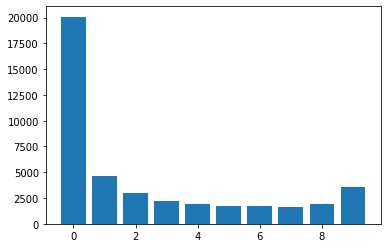

In [4]:
import collections
import matplotlib.pyplot as plt

plt.bar(check_initial.keys(), check_initial.values())

In [ ]:
if os.path.exists("dataset2"):
    pass
    # shutil.rmtree('dataset2')
if os.path.exists("dataset2_check/images"):  
    pass
    # shutil.rmtree('dataset2_check/images')
if os.path.exists("dataset2_check/masks"): 
    pass
    # shutil.rmtree('dataset2_check/masks')
    
    
os.makedirs('dataset2', exist_ok=True)
os.makedirs('dataset2_check/images', exist_ok=True)
os.makedirs('dataset2_check/masks', exist_ok=True)

from collections import Counter

def create_other_dataset(fname):    
    I = np.asarray(Image.open(f'intermediate/{fname}'))

    cv2.imwrite(f'dataset2/{fname}',I[:, :, [2,1,0,3]])
    cv2.imwrite(f'dataset2_check/masks/{fname}',I[:, :, 3])
    cv2.imwrite(f'dataset2_check/images/{fname}',I[:, :, [2,1,0]])

with Pool(20) as p:
    p.map(create_other_dataset, use_fnames)
    
#check_final = Counter(filter(None, p_map(create_other_dataset,  os.listdir('intermediate'))))



In [22]:
'BGR'[::-1]

'RGB'

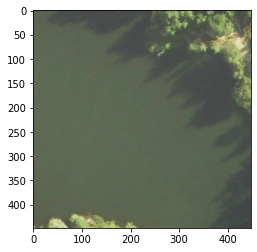

In [19]:
mask = cv2.imread('dataset2_check/images/M-33-20-D-d-3-3-11-30.png')
plt.imshow(mask[:, :, ::-1])

In [ ]:
!ls dataset2_check | wc -l

In [23]:
#!ls dataset2_check/images | head -100

In [ ]:
!ls dataset2_check/masks | wc -l

In [ ]:
# There exist empty files after the splitting and rotating:

for fname in tqdm(os.listdir('intermediate')):
    if not fname.endswith('png'):
        continue
        
    I = np.asarray(Image.open(f'intermediate/{fname}'))

    if I.shape != (448, 448, 4):
        #print(I.shape, fname)

In [ ]:
i = 0
list_mv = []
list_overpopulated = []
from collections import Counter

# old, much slower:

if False:
    for image in tqdm(tiles):
        # np.asarray(Image.open(fname))
        # dummy filter
        #
        print(image[1])
        print(image[0].shape)
        if image[0][:, :, -1].max() == 0 or image[0][:, :, -1].min() == 255:
            continue

        i += 1
        mv = image[0][:, :, -1].mean().item() // (0.1 * 255) 
        list_mv.append(mv)

        water_counter = Counter(item for item in list_mv) 

        for k in water_counter:
            if water_counter[k] > 5000:
                list_overpopulated.append(k)
        if mv in list_overpopulated:
            continue
            #pass # to check the initial distribution
        cv2.imwrite(f'dataset2/{image[2]}_{image[1]}_{image[3]}.png',image[0][:, :, [2,1,0,3]])
        cv2.imwrite(f'dataset2_check/masks/{image[2]}_{image[1]}_{image[3]}.png',image[0][:, :, 3] * 255)
        cv2.imwrite(f'dataset2_check/images/{image[2]}_{image[1]}_{image[3]}.png',image[0][:, :, [2,1,0]])

    # tiles_resized.append(image_resized)
#plt.imshow(MM)

In [ ]:
# just checking: 

I = np.ones((4678, 4113, 4), dtype=np.uint8) * 255

def get_rotated_crops(I, angle, crop_size=(448,448), num_crops=2):
    if angle == 0:
        mask = np.zeros_like(I[:, :, 0])
        mask[:mask.shape[0]-crop_size[0], :mask.shape[1]-crop_size[1]] = 1
    else:
        angler = angle * np.pi / 180
        II = scipy.ndimage.rotate(I, angle)
        mask = scipy.ndimage.rotate(np.ones_like(I[:, :, 0]), angle)
        kernel = np.ones((crop_size[0] + 1, crop_size[1] + 1), dtype=np.uint8)
        mask = cv2.erode(mask, kernel, anchor=(0,0))
    
    
    plt.imshow(mask)
    #plt.imshow(II)
    #x, y = mask.nonzero()
    
    #p = (x*x + y*y).argsort()[-1000:]
    
#     for x0, y0 in zip(x[p], y[p]):
#         if II[x0:x0 + crop_size[0], y0:y0 + crop_size[1]].min() != 255:
#             print(xx, yy)
    
#     L = len(x)
#     for c in np.random.randint(0, L, size=num_crops):
#         x0 = x[c]
#         y0 = y[c]
#         yield II[x0:x0 + crop_size[0], y0:y0 + crop_size[1]]
#         break
        
get_rotated_crops(I, 0)